# Setting up Environment for google.colab

In [1]:
# Creating kaggle.json file with API tokens

![ -d sample_data ] && rm -rf sample_data

!echo '{"username":"garakhantalibov","key":"819f819ec679662985b5abea0c29d37b"}' > kaggle.json

In [2]:
#Place kaggle.json to /root/.kaggle

![ ! -d /root/.kaggle ] && mkdir /root/.kaggle && mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Install kaggle==1.5.6, default kaggle in colab is outdated
!pip install kaggle==1.5.6 &> /dev/null

In [3]:
#Download dataset
print('{:<30}'.format("Downloading dataset..."), end="")
! [ ! -f shopee-product-matching.zip ] && kaggle competitions download -c shopee-product-matching
print ("+[DONE]")
print ('{:<30}'.format("Unzipping dataset..."), end="")
! [ ! -d shopee-product-matching ] && unzip -q shopee-product-matching.zip
print ("+[DONE]")

 99% 1.67G/1.68G [00:12<00:00, 106MB/s]
100% 1.68G/1.68G [00:12<00:00, 144MB/s]
+[DONE]
Unzipping dataset...          +[DONE]


In [4]:
import sys
import subprocess
import pkg_resources

required={"transformers", "efficientnet_pytorch", "opencv-python", "torchvision",
          "torch", "sklearn", "numpy", "pandas", "matplotlib", 'tqdm', "geffnet",
          "IPython"}
installed={pkg.key for pkg in pkg_resources.working_set}
missing=required-installed

if missing:
  print(f"Could not found packages {missing}...")
  for i in missing:
    try:
      subprocess.check_call(["pip", "install", i])
      print ("Installed package ", i)
    except:
      print(f"Cannot be installed package ", i)

Could not found packages {'IPython', 'transformers', 'efficientnet_pytorch', 'geffnet'}...
Installed package  IPython
Installed package  transformers
Installed package  efficientnet_pytorch
Installed package  geffnet


# Importing Utils and Reading Data

In [5]:
import torch

dev="cuda" if torch.cuda.is_available() else "cpu"
if dev=="cuda":
  print (f"Available gpu is :{torch.cuda.get_device_name (dev)}.")
else:
  print (f"GPU not available :{torch.cuda.get_device_name(dev)}.")

Available gpu is :Tesla P100-PCIE-16GB.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn, torch.nn.functional as F
from torch import multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as A
from efficientnet_pytorch import EfficientNet # EfficientNet implementation on pytorch for image embedding
from transformers import AutoTokenizer, AutoModel
import os, cv2 as cv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import geffnet
from IPython.display import clear_output

In [7]:
# tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')
# text_model=AutoModel.from_pretrained('bert-base-uncased')

# Downloads pre-trained efficientnet-b7
image_model=EfficientNet.from_pretrained('efficientnet-b7')

# image_model=geffnet.create_model('tf_efficientnet_b0_ns', pretrained=None)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [8]:
# When submitting path will read test images

SUBMIT=False
csv="train.csv"
img_dir="./train_images/"
if SUBMIT:
  csv="input/shopee-product-matching/test.csv"
  img_dir="input/shopee-product-matching/test_images/"

In [9]:
# Changes the image names in "image" column to number.jpg for convenience, original name was long string
# Changes label group to number of unique label_group entries for convenience
# label_group is already a provided labels that define if the posting is related to the same product
# postings related to the same product is labeled with the same.
# grouped_images column shows the images that are labbeled the same
# label_group column is taken as target

data=pd.read_csv (csv)
target=np.array(list(set(data.label_group.values)))
target_dict={target[i]:i for i in range (len(target))}
data.label_group=[target_dict[data.iloc[i].label_group] for i in range(len(data))]
image_dict={f"{i+1}.jpg":data.iloc[i].image for i in range (len(data))}
data.image=np.array([f"{i}.jpg" for i in range (1, len(data)+1)])
grouped_images = data.groupby('label_group').image.agg('unique').to_dict()
data['grouped_images']=data.label_group.map (grouped_images)
data.head()

,posting_id,image,image_phash,title,label_group,grouped_images
0,train_129225211,1.jpg,94974f937d4c2433,Paper Bag Victoria Secret,4185,"[1.jpg, 33162.jpg]"
1,train_3386243561,2.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2044,"[2.jpg, 18684.jpg]"
2,train_2288590299,3.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2368,"[3.jpg, 15669.jpg]"
3,train_2406599165,4.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10170,"[4.jpg, 11028.jpg]"
4,train_3369186413,5.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,5887,"[5.jpg, 18450.jpg]"


In [10]:
# Splitting dataset

X_train, X_test, y_train, y_test=train_test_split (data, data.label_group, test_size=0.33)
X_val, X_test, y_val, y_test=train_test_split (X_test, y_test, test_size=0.16)

In [11]:
# Data Augmentation using albumentation library

transform = A.Compose([
    # A.Resize(256, 256), 
    A.RandomCrop(256, 256),
    A.OneOf([
                          A.HorizontalFlip(p=1),
                          A.RandomRotate90(p=1),
                          A.VerticalFlip(p=1)            
    ], p=1),
    A.OneOf([
                          A.MotionBlur(p=1),
                          A.OpticalDistortion(p=1),
                          A.GaussNoise(p=1)                 
    ], p=1),
    # A.pytorch.ToTensor()
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

In [12]:
# Preparing dataset
# This class allowes to access any item of dataset by ShopData()[idx]
# It also allows to load batches of dataset with DataLoader class of pytorch
# ShopData()[idx] returns tensor of image and label image from label_group column
# Transform in the previous cell for data augmentation is used here

class ShopData (Dataset):
    
    def __init__ (self, df=data, img_dir=img_dir,
                  transformer=transform, image_dict=image_dict, device="cpu"):
      
        self.df=df   #imported cvs table
        self.img_dir=img_dir #image directory path
        self.transform=[None, transformer]
        self.device=device
    
    def __len__ (self):
        return (len(self.df))
    
    def __getitem__(self, index):
      
        if torch.is_tensor(index):
          index=index.tolist()
      
        row=self.df.iloc[index] #row item
        path=os.path.join (self.img_dir, image_dict[row.image]) #storing image path

        img=cv.imread(path)
        img=cv.cvtColor (img, cv.COLOR_BGR2RGB)
        # img=cv.resize(img, (512, 512))
        trans=np.random.choice(self.transform, p=[0.3, 0.7])
        if trans is not None:
          img=cv.resize(img, (512, 512))
          img=trans(image=img)['image'].transpose(2, 0, 1)
        else:
          img=cv.resize(img, (256, 256)).transpose(2, 0, 1)
        
        return torch.tensor(img, dtype=torch.int64).to(self.device), row.label_group

8 images from Train dataset: 



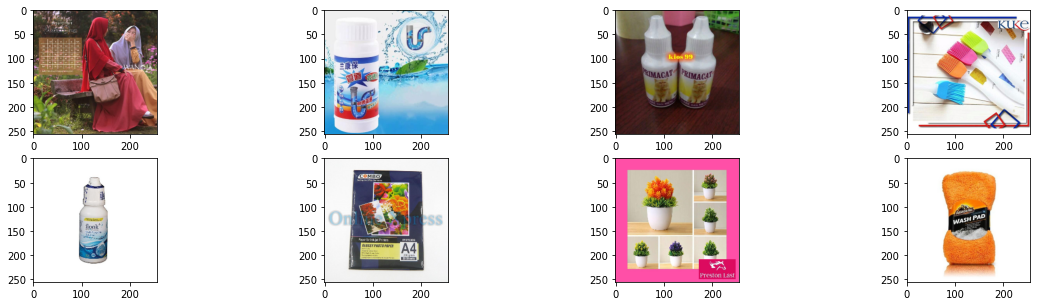

In [13]:
n=2**3
row=2
fig, ax= plt.subplots(row, int(n/row), figsize=(20, 5))
slots=ax.ravel()

print (f"{n} images from Train dataset: \n")
n=np.random.choice([i for i in range (len(data))], 8)

for i in range(len(n)):
  slots[i].imshow (ShopData(transformer=None)[n[i]][0].numpy().transpose(1, 2, 0))

In [14]:
# this class is built on efficientnet-b7 model with additional dense output
# output returns len(label_group) ouput for classification

class ImageEmbedding (nn.Module):

    def __init__ (self, enet=image_model, out_features=len(grouped_images)):
        super().__init__()
        self.model=image_model
        self.dense=nn.LazyLinear(out_features)
    
    def forward (self, X):
        # self.model.eval()
        output=self.model(X.float())
        output=self.dense(output)
        
        return output

In [15]:
BATCH_SIZE=16
SHUFFLE=True
EPOCH=100
ITER_THROUGH=200
train_hist, val_hist=[], []
train_acc, val_acc=[], []

train_dataset=ShopData(df=X_train)
val_dataset=ShopData(df=X_val)
test_dataset=ShopData(df=X_test)


# Loads batches of data
train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader=DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [16]:
# Loss function is CrossEntropy

'''
The idea for training (needs to be improved):

  Each time the batch of data (in this case it is 32) is loaded, it with 0.3 prob stays original, or
  with 0.7 prob is transformed with random ways, like flipping, shifting RGB, cropping etc. This is done because 
  dataset is ~30000, and labels (classes) is ~11000. 


'''

model=ImageEmbedding().to(dev)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-5)
loss_func=nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch:  1
Currently:
Train loss =  0.5816825386881829
Val loss =  400.1975881457329
Train Acc =  0.0625
Val Acc =  9.084302325581395e-05
True labels: 
 [6241  838 7314 2059 3732 5807  119  837 7333 4314 6653 3046 3180 3815
 8039 1574]
Predicted: 
 tensor([ 1240,   104,  3475,  7723,  8484,  7838,  5068,  8302, 10882,  2300,
         1048,  8505,  3882, 10517,  9008,  2315])


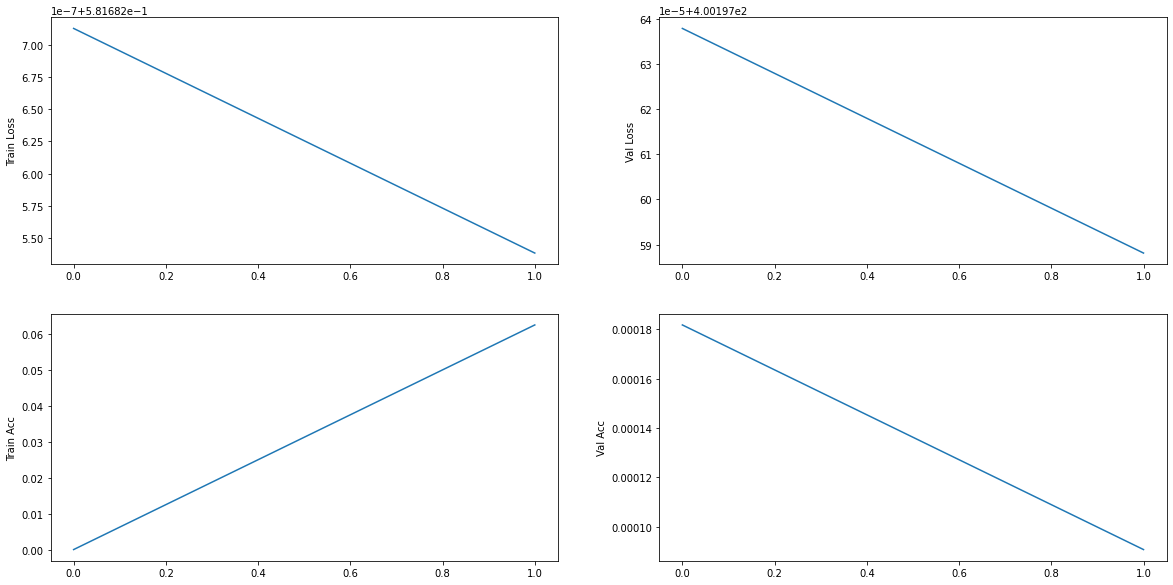

 69%|██████▉   | 474/688 [02:59<01:21,  2.63it/s]


KeyboardInterrupt: ignored

In [17]:
for epoch in range(EPOCH):
  
  train_loss, val_loss=0, 0
  train_score, val_score=0, 0
  
  model.train(True)
  for iter_through in tqdm(range(ITER_THROUGH)):

    images, labels=next(iter(train_loader))
    out=model(images.to(dev))
    out=torch.nn.Softmax(dim=1)(out)
    pred=torch.argmax(out.cpu(), dim=1)

    train_score+=accuracy_score(pred, labels)

    labels=F.one_hot(labels, num_classes=len(grouped_images))
    loss=loss_func(out, labels.float().to(dev))
    del out
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    
    train_loss+=loss.data.cpu().numpy()/BATCH_SIZE

  train_hist.append(train_loss/ITER_THROUGH)
  train_acc.append(train_score)

  model.train(False)
  with torch.no_grad():
    for iter_through in tqdm(range(int(len(grouped_images)/BATCH_SIZE))):
      images, labels=next(iter(val_loader))
      out=model(images.to(dev))
      out=torch.nn.Softmax(dim=1)(out)
      pred=torch.argmax(out.cpu(), dim=1)

      val_score+=accuracy_score(pred, labels)

      labels=F.one_hot(labels, num_classes=len(grouped_images))
      loss=loss_func(out, labels.float().to(dev))
      del out

      
      val_loss+=loss.data.cpu().numpy()/BATCH_SIZE
  
  val_acc.append(val_score/(int(len(grouped_images)/BATCH_SIZE)))
  val_hist.append(val_loss)

  if min(val_hist)>=val_loss:
    path="./drive/MyDrive/HSE/MLDM-2021/Project/Developed/model.ckpt"
    torch.save({"epoch":epoch, 
                "model_state_dict":model.state_dict(),
                "optimizer_state_dict":optimizer.state_dict(),
                "train_loss":train_hist,
                "val_loss":val_hist,
                "train_acc":train_acc,
                "val_acc":val_acc,
                "batch_size":BATCH_SIZE,
                "iter_through":ITER_THROUGH,
                "learning_rate":1e-5,
                "loss_func":"nn.CrossEntropyLoss()"}, path)
  

  clear_output(True)
  print ("Epoch: ", epoch)
  
  fig, ax=plt.subplots(2, 2, figsize=(20, 10))
  # print (train_hist)
  ax[0, 0].plot(range(len(train_hist)), train_hist)
  ax[0, 1].plot(range(len(val_hist)), val_hist)
  ax[1, 0].plot(range(len(train_acc)), train_acc)
  ax[1, 1].plot(range(len(val_acc)), val_acc)
  ax[0, 0].set_ylabel("Train Loss")
  ax[0, 1].set_ylabel("Val Loss")
  ax[1, 0].set_ylabel("Train Acc")
  ax[1, 1].set_ylabel("Val Acc")

  print ("Currently:")
  print ("Train loss = ", train_hist[-1])
  print ("Val loss = ", val_hist[-1])
  print ("Train Acc = ", train_acc[-1])
  print ("Val Acc = ", val_acc[-1])
  print ("True labels: \n", np.argmax(labels.cpu().numpy(), axis=1))
  print ("Predicted: \n", pred)

  plt.show()